# Autoencoder training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from itertools import product
from nn import nn

Load digits dataset from sklearn and split data into training and testing sets using train_test_split

In [2]:
np.random.seed(1)
digits = load_digits()
X_train, X_val, y_train, y_val = train_test_split(digits["data"], digits["target"],
                                                 test_size = 0.3, 
                                                 random_state = 1)
print("Training data " + str(X_train.shape))
print("Testing data " + str(X_val.shape))

Training data (1257, 64)
Testing data (540, 64)


## 3-fold cross validation for tuning of neural network layers
Parameters to test:
* Number of layers: 2 vs 4
* Number of batches: 100 vs 200
* Number of epochs: 50 vs 100

For the number of layers in the neural network, because we are trying to recreate the original image that has 64 features associated with each image rather than classify the labels, our output dimension is also 64. If we were to just try to classify what number that image is, our output dimension would be 1. 
For all layers, we will use a relu activation as the values fall along a continuous scale rather than a categorical value for which we would consider using a sigmoid activation.

In [3]:
num_cv = 3 # number of cross validation folds
# Create dataframe to store training results
cols = ["idx", "train_error", "val_error",]
tune_res = pd.DataFrame(columns = cols)

# Split the training set into three folds
kf = KFold(n_splits = num_cv)

# Define the parameters
num_layers = {2: [{"input_dim": 64, "output_dim": 16, "activation": "relu"},
                  {"input_dim": 16, "output_dim": 64, "activation": "relu"}],
              4: [{'input_dim': 64, 'output_dim': 32, 'activation': 'relu'},
                  {'input_dim': 32, 'output_dim': 16, 'activation': 'relu'},
                  {'input_dim': 16, 'output_dim': 32, 'activation': 'relu'},  
                  {'input_dim': 32, 'output_dim': 64, 'activation': 'relu'}]}
num_batches = {100: 100, 
               200: 200}
num_epochs = {100: 100,
              500: 500}

# Create a grid of parameter iterations
d = {'Layers':[2, 4], 
     'Batches':[100, 200],
     'Epochs':[100, 500]}
param_grid = [dict(zip(d, v)) for v in product(*d.values())]
param_grid

[{'Layers': 2, 'Batches': 100, 'Epochs': 100},
 {'Layers': 2, 'Batches': 100, 'Epochs': 500},
 {'Layers': 2, 'Batches': 200, 'Epochs': 100},
 {'Layers': 2, 'Batches': 200, 'Epochs': 500},
 {'Layers': 4, 'Batches': 100, 'Epochs': 100},
 {'Layers': 4, 'Batches': 100, 'Epochs': 500},
 {'Layers': 4, 'Batches': 200, 'Epochs': 100},
 {'Layers': 4, 'Batches': 200, 'Epochs': 500}]

In [4]:
# Iterate through the parameter grid
for idx, _ in enumerate(param_grid):
    # Get current parameters
    l = param_grid[idx]['Layers']
    b = param_grid[idx]['Batches']
    e = param_grid[idx]['Epochs']
    print("Testing parameter set " + str(idx))
    print("Layers = " + str(l) + ", Batches = " + str(b) + ", Epochs = " + str(e))
    
    fold_train_loss = []
    fold_val_loss = []
    
    tune_res.loc[idx, "idx"] = idx
    # Iterate through the CV folds
    for cv_fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        # print("Testing fold #" + str(cv_fold + 1))
        
        # Initialize neural network with current parameters
        net = nn.NeuralNetwork(nn_arch = num_layers[l],
                               batch_size = num_batches[b],
                               epochs = num_epochs[e],
                               lr = 0.0001,
                               seed = 1,
                               loss_function = "mse",
                               verbose = True)
        # Get fold-specific training and testing data
        train_loss, val_loss = net.fit(X_train[train_idx], X_train[train_idx],
                                       X_train[val_idx], X_train[val_idx])
        
        # Calculate average loss
        fold_train_loss.append(np.mean(train_loss))
        fold_val_loss.append(np.mean(val_loss))
    
    tune_res.loc[idx, "train_error"] = np.mean(fold_train_loss)
    tune_res.loc[idx, "val_error"] = np.mean(fold_val_loss)

Testing parameter set 0
Layers = 2, Batches = 100, Epochs = 100
Number of batches: 9.0
Finished epoch 1 out of 100
Finished epoch 11 out of 100
Finished epoch 21 out of 100
Finished epoch 31 out of 100
Finished epoch 41 out of 100
Finished epoch 51 out of 100
Finished epoch 61 out of 100
Finished epoch 71 out of 100
Finished epoch 81 out of 100
Finished epoch 91 out of 100
Completed NN fitting
Number of batches: 9.0
Finished epoch 1 out of 100
Finished epoch 11 out of 100
Finished epoch 21 out of 100
Finished epoch 31 out of 100
Finished epoch 41 out of 100
Finished epoch 51 out of 100
Finished epoch 61 out of 100
Finished epoch 71 out of 100
Finished epoch 81 out of 100
Finished epoch 91 out of 100
Completed NN fitting
Number of batches: 9.0
Finished epoch 1 out of 100
Finished epoch 11 out of 100
Finished epoch 21 out of 100
Finished epoch 31 out of 100
Finished epoch 41 out of 100
Finished epoch 51 out of 100
Finished epoch 61 out of 100
Finished epoch 71 out of 100
Finished epoch 8

Completed NN fitting
Number of batches: 5.0
Finished epoch 1 out of 500
Finished epoch 51 out of 500
Finished epoch 101 out of 500
Finished epoch 151 out of 500
Finished epoch 201 out of 500
Finished epoch 251 out of 500
Finished epoch 301 out of 500
Finished epoch 351 out of 500
Finished epoch 401 out of 500
Finished epoch 451 out of 500
Completed NN fitting


In [5]:
# Results of tuning
tune_res

,idx,train_error,val_error
0,0,20.021321,19.964817
1,1,13.207841,13.3264
2,2,23.536517,23.40896
3,3,15.806777,15.888342
4,4,18.991241,18.796733
5,5,9.180445,9.324679
6,6,22.771862,22.576325
7,7,12.302578,12.416338


In [6]:
# Get parameters of the tuning with the lowest validation error
opt_idx = tune_res["val_error"].astype(float).idxmin()
# Print parameters
print("Lowest validation with the following parameters:")
print("Layers: " + str(param_grid[opt_idx]['Layers']))
print("Batches: " + str(param_grid[opt_idx]['Batches']))
print("Epochs: " + str(param_grid[opt_idx]['Epochs']))

Lowest validation with the following parameters:
Layers: 4
Batches: 100
Epochs: 500


# Run model with tuned parameters
Given the outputs of the tuning, run with the "optimal parameters", training on the full dataset and validating on the test dataset. Again, using the true "pixel" values as the "labels"

In [7]:
net = nn.NeuralNetwork(nn_arch = num_layers[param_grid[opt_idx]['Layers']],
                       batch_size = num_batches[param_grid[opt_idx]['Batches']],
                       epochs = num_epochs[param_grid[opt_idx]['Epochs']],
                       lr = 0.0001,
                       seed = 1,
                       loss_function = "mse",
                       verbose = True)

train_loss, val_loss = net.fit(X_train, X_train, X_val, X_val)

Number of batches: 13.0
Finished epoch 1 out of 500
Finished epoch 51 out of 500
Finished epoch 101 out of 500
Finished epoch 151 out of 500
Finished epoch 201 out of 500
Finished epoch 251 out of 500
Finished epoch 301 out of 500
Finished epoch 351 out of 500
Finished epoch 401 out of 500
Finished epoch 451 out of 500
Completed NN fitting


Plot the training and validation losses

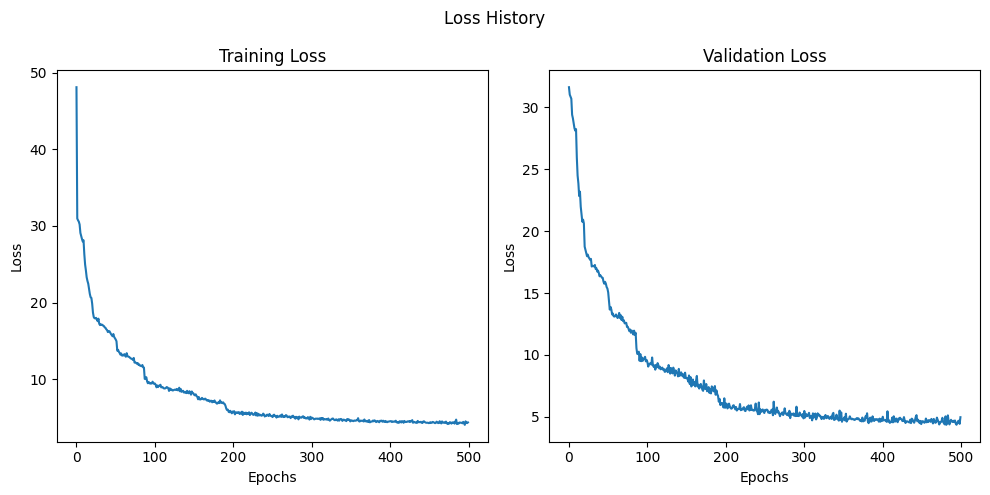

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Loss History')
axs[0].plot(np.arange(len(train_loss)), train_loss)
axs[0].set_title('Training Loss')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel('Loss')
axs[1].plot(np.arange(len(val_loss)), val_loss)
axs[1].set_title('Validation Loss')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel('Loss')
fig.tight_layout()
plt.show() 

Cherry pick an image that looks somewhat decent (ツ)_/¯. TBD if it's a 7 or a 9

Average prediction error: 4.9622


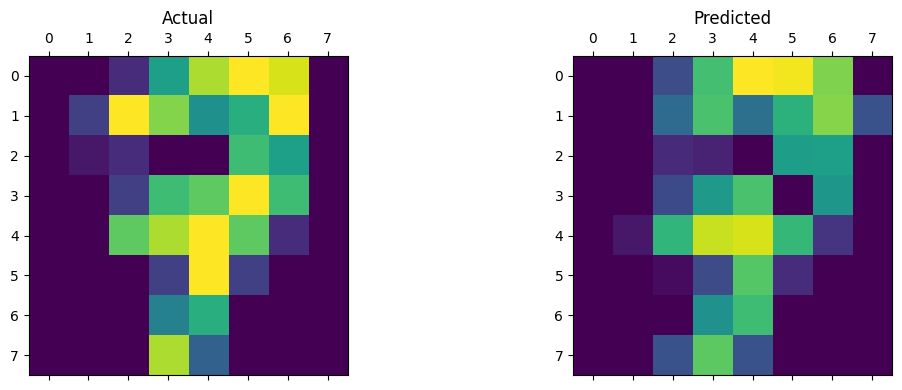

In [9]:
pred = net.predict(X_val)
pred_err = mean_squared_error(X_val, pred)
print("Average prediction error: " + str(round(pred_err, 4)))

fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].matshow(X_val[3].reshape((8, 8)))
ax[0].set_title("Actual")
ax[1].matshow(pred[3].reshape((8, 8)))
ax[1].set_title("Predicted")
fig.tight_layout()
plt.show() 